# Problem Statement

You are given the original and degraded versions of a few images. Your task is to write a GAN which can fix the degraded images.

Complete the function `fix` at the end of the "Evaluation" block so that it can take a degraded image, and return a fixed image (that looks as much like the original non-degraded version as possible). **Read the doc-string of the fix function to see the format it expects, otherwise the displayed images will look extremely strange.**

Before submission, get this notebook in a state such that the `fix` function can directly be called on an image. Also, please make sure that 5 images are displayed in the result block. Without that, your submission will not be evaluated.

#Setup

## Intended Structure after Setup

Run the blocks in this section to get the following directory structure:
```
/content
│
└───rephrase-pubfig831
    │
    └───correct
    │   │
    │   └───train
    │   │   │
    │   │   └───Adam Sandler
    │   │   │   │   train__000001-000000.jpg
    │   │   │   │   train__000001-000001.jpg
    │   │   │   │   train__000001-000002.jpg
    │   │   │   │   ...
    │   │   │
    │   │   └───Alec Baldwin
    │   │   │   │   train__000002-000000.jpg
    │   │   │   │   train__000002-000001.jpg
    │   │   │   │   ...
    │   │   │
    │   │   └───Angelina Jolie
    │   │   │   │   train__000003-000000.jpg
    │   │   │   │   train__000003-000001.jpg
    │   │   │   │   ...
    │   │   │
    │   │   │ ...
    │   │
    │   └───test
    │       │
    │       └───Adam Sandler
    │       │   │   test__000001-000000.jpg
    │       │   │   test__000001-000001.jpg
    │       │   │   ...
    │       │
    │       └───Alec Baldwin
    │       │   │   test__000002-000000.jpg
    │       │   │   ...
    │       │
    │       └───Angelina Jolie
    │       │   │   test__000003-000000.jpg
    │       │   │   ...
    │       │
    │       │ ...
    │
    │
    └───degraded
        │   <Same directory structure as 'correct'>
```

Every image in the degraded directory is a degraded version of the image with the same name in the correct directory. e.g. `/content/rephrase-pubfig831/degraded/Adam Sandler/train__000001-000002.jpg` is the degraded version of `/content/rephrase-pubfig831/correct/Adam Sandler/train__000001-000002.jpg`

## Installation (pip etc)
Add any other installation commands you want to in this block.

In [0]:
!pip install GPUtil
!pip install tqdm
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install tensorflow==2.0.0-beta
!pip install keras==2.3.0
!pip install -q --upgrade ipython==5.5.0
!pip install -q --upgrade ipykernel==4.6.0

  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=c26fc59e6cc7055573c9194d51ea23cbdae77cdcd41ae3864760eb32436deae1
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil
     |████████████████████████████████| 87.9MB 35kB/s 
     |████████████████████████████████| 3.1MB 29.5MB/s 
     |████████████████████████████████| 501kB 54.9MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0
     |████████████████████████████████| 378kB 2.7MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5
     |████████████████████████████████| 112kB 2.8MB/s 


## Downloading and Generating Dataset
Run this block only once. Do not modify it. Also, don't call the degrade function in your code anywhere. You should treat the degradation process as a black box.

In [0]:
import os
from glob import glob

import cv2
import numpy as np
from tqdm import tqdm

def degrade(path: str) -> None:
    """Load image at `input_path`, distort and save as `output_path`"""
    SHIFT = 2
    image = cv2.imread(path)
    to_swap = np.random.choice([False, True], image.shape[:2], p=[.8, .2])
    swap_indices = np.where(to_swap[:-SHIFT] & ~to_swap[SHIFT:])
    swap_vals = image[swap_indices[0] + SHIFT, swap_indices[1]]
    image[swap_indices[0] + SHIFT, swap_indices[1]] = image[swap_indices]
    image[swap_indices] = swap_vals
    cv2.imwrite(path, image)

!wget http://briancbecker.com/files/downloads/pubfig83lfw/pubfig83lfw_raw_in_dirs.zip
!unzip -q pubfig83lfw_raw_in_dirs.zip
!rm pubfig83lfw_raw_in_dirs.zip
!mkdir rephrase-pubfig831
!mv pubfig83lfw_raw_in_dirs rephrase-pubfig831/correct
#!rm -r rephrase-pubfig831/correct/distract
!cp -r rephrase-pubfig831/correct rephrase-pubfig831/degraded

for image_path in tqdm(glob('rephrase-pubfig831/degraded/*/*/*.jpg')):
  degrade(image_path)

--2020-01-10 03:43:06--  http://briancbecker.com/files/downloads/pubfig83lfw/pubfig83lfw_raw_in_dirs.zip
Resolving briancbecker.com (briancbecker.com)... 162.241.216.158
Connecting to briancbecker.com (briancbecker.com)|162.241.216.158|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400247922 (382M) [application/zip]
Saving to: ‘pubfig83lfw_raw_in_dirs.zip’

pubfig83lfw_raw_in_ 100%[===================>] 381.71M  16.9MB/s    in 24s     

2020-01-10 03:43:30 (15.9 MB/s) - ‘pubfig83lfw_raw_in_dirs.zip’ saved [400247922/400247922]



100%|██████████| 13002/13002 [01:02<00:00, 206.52it/s]


# **Checking Free Memory**
This block is just so that you can have an idea of the resources you have at hand on the Google Collab system.

In [0]:
import psutil
import humanize
import os
import GPUtil as GPU
gpu = GPU.getGPUs()[0]
process = psutil.Process(os.getpid())
print(f"Gen RAM: Free {humanize.naturalsize(psutil.virtual_memory().available)} | Proc size {humanize.naturalsize(process.memory_info().rss)}")
print(f"GPU RAM: Free {gpu.memoryFree:.0f}MB | Used {gpu.memoryUsed:.0f}MB | Util {gpu.memoryUtil*100:.0f}% | Total {gpu.memoryTotal:.0f}MB")

Gen RAM: Free 26.3 GB | Proc size 156.5 MB
GPU RAM: Free 16280MB | Used 0MB | Util 0% | Total 16280MB


# **Main Code**

## Data Loading

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [0]:
train_img=[]
train_hr_path = '/content/rephrase-pubfig831/degraded/train'
for subdir, dirs, _ in os.walk(train_hr_path):
  for file in dirs:
    path = os.path.join(subdir,file)
    for i in os.listdir(path):
      img = cv2.imread(os.path.join(path,i))
      img = cv2.resize(img , (250,250))
      train_img.append(img)
train_img = np.array(train_img).astype('uint8')

real_img=[]
train_lr_path = '/content/rephrase-pubfig831/correct/train'
for subdir, dirs, _ in os.walk(train_lr_path):
  for file in dirs:
    path = os.path.join(subdir,file)
    for i in os.listdir(path):
      img = cv2.imread(os.path.join(path,i))
      img = cv2.resize(img , (250,250))
      real_img.append(img)
real_img = np.array(real_img).astype('uint8')

print(train_img.shape)  
print(real_img.shape)

(8720, 250, 250, 3)
(8720, 250, 250, 3)


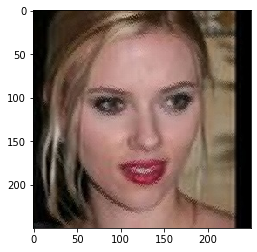

In [0]:
plt.imshow(train_img[0][:,:,::-1])

In [0]:
batch_size = 1
batch_count = (real_img.shape[0]//batch_size)

## Structure

### **Constants and Hyperparemeters**

In [0]:
import tensorflow as tf
learning_rate = 0.0001

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [0]:

tf.__version__

'2.0.0-beta0'

### Generator Model

In [0]:
def generator():
  
  inp = tf.keras.layers.Input(shape=(250,250,3))
  l1=(tf.keras.layers.Conv2D(64,(3,3),padding='same',activation='relu'))(inp)
  l1=(tf.keras.layers.BatchNormalization(momentum=0.8))(l1)
  nn = l1
  for i in range(0,6):
    res=(tf.keras.layers.Conv2D(64,(3,3),padding='same',activation='relu'))(nn)
    #res=(tf.keras.layers.BatchNormalization(momentum=0.5))(res)
    nn = res
    residual_out = tf.keras.layers.add([l1,res])
  l2=(tf.keras.layers.Conv2D(64,(3,3),padding='same',activation='relu'))(residual_out)
  l3=(tf.keras.layers.Conv2D(3,(3,3),padding='same',activation='tanh'))(l2)
  final = (tf.keras.layers.BatchNormalization())(l3)

  model = tf.keras.models.Model(inputs = inp , outputs = final)
  model.summary()
  return model
  

In [0]:
model_generator = generator()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 250, 250, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 250, 250, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 250, 250, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 250, 250, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

(1, 250, 250, 3)


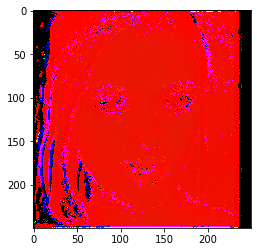

In [0]:
img = np.reshape(train_img[0],(1,250,250,3))
trial = tf.image.convert_image_dtype(img,tf.float32)
new = tf.image.convert_image_dtype(real_img[0],tf.float32)
pred = model_generator.predict(trial)
pred = tf.image.convert_image_dtype(pred,tf.uint8)
pred = pred[:,:,:,::-1] 

plt.imshow(tf.reshape(pred[0],(250,250,3)))
print(pred.shape)

In [0]:
def discriminator():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(64,(3,3),input_shape=(250,250,3)))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Conv2D(64,(3,3),input_shape=(250,250,3)))
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(32,activation='relu'))
  model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
  return model

In [0]:
model_discriminator = discriminator()


### Loss Functions

In [0]:
def loss_disc(real_output,fake_output):
  real_output = tf.sigmoid(real_output)
  fake_output = tf.sigmoid(fake_output)
  real_loss = tf.losses.binary_crossentropy(tf.ones_like(batch_size),real_output)
  fake_loss = tf.losses.binary_crossentropy(tf.zeros_like(batch_size),fake_output)
  return real_loss + fake_loss

def loss_gen(fake_output):
  fake_output = tf.sigmoid(fake_output)
  fake_loss = tf.losses.binary_crossentropy(tf.ones_like(batch_size),fake_output)
  return fake_loss

In [0]:
resnet = tf.keras.applications.resnet50.ResNet50(include_top=False , weights = 'imagenet',input_shape=(250,250,3))
resnet.trainable = False
model_res = tf.keras.models.Model(inputs = resnet.input ,outputs= resnet.output)
model_res.trainable = False
def resnet_loss(real,fake):
  hr = model_res.predict(real)
  lr = model_res.predict(fake)
  loss = tf.keras.losses.mean_squared_error(hr,lr)
  return np.mean(loss)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
def color_loss(real,fake):
  loss = tf.keras.losses.mean_squared_error(real,fake)
  return (loss)

### Optimizer

In [0]:
optimizer_gen = tf.keras.optimizers.Adam(learning_rate)
optimizer_disc = tf.keras.optimizers.Adam(learning_rate)

## Preprocessing

### Setting device to use for tensor operations

### Initializing weights (if required)

In [0]:
trained_model = tf.keras.models.load_model('/content/new.h5')

## Training

In [0]:
def start(epochs):
  for e in range(epochs):
      train_model(e)
      if e%5 == 0:
        model_generator.save('/content/train_model.h5')

In [0]:
def train_model(e):
  rand = np.random.randint(0,train_img.shape[0],size = batch_size)
  low=[]
  high=[]
  for num in rand:
    low.append(train_img[num])
    high.append(real_img[num])
  low = np.array(low).astype('float32')
  high = np.array(high).astype('float32')

  noise_image = low/255

  with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
    generated_image = model_generator(noise_image)

    r_image= high/255
    real_output = model_discriminator(r_image)
    fake_output = model_discriminator(generated_image)

    real_loss = loss_disc(real_output,fake_output)
    fake_loss_out = loss_gen(fake_output)
    loss_mse = color_loss(r_image,generated_image)
    content_loss = resnet_loss(r_image , generated_image)
    fake_loss = content_loss + fake_loss_out+loss_mse 

    gradient_gen = gen_tape.gradient(fake_loss , model_generator.trainable_variables)
    gradient_disc = disc_tape.gradient(real_loss , model_discriminator.trainable_variables)

    optimizer_disc.apply_gradients(zip(gradient_disc,model_discriminator.trainable_variables))
    optimizer_gen.apply_gradients(zip(gradient_gen,model_generator.trainable_variables))

    print('Epoch : {} , loss: {}'.format(e,np.mean(fake_loss)))

In [0]:
start(batch_count)

## Evaluation

(1, 250, 250, 3)


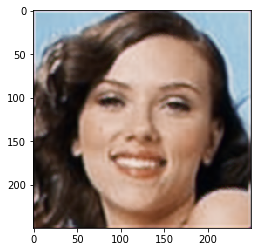

In [0]:
trial = np.reshape(train_img[1],(1,250,250,3))
trial = trial/255
trial = trial.astype('float32')

new = tf.image.convert_image_dtype(real_img[8534],tf.float32)
pred = trained_model.predict(trial)
pred = tf.image.convert_image_dtype(pred,tf.uint8)

pred = pred[:,:,:,::-1]

plt.imshow(tf.reshape(pred,(250,250,3)))
print(pred.shape)

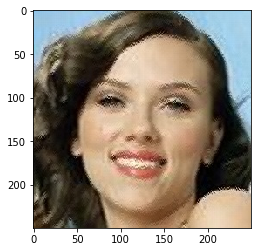

In [0]:
r = (train_img[1])
plt.imshow(r[:,:,::-1])

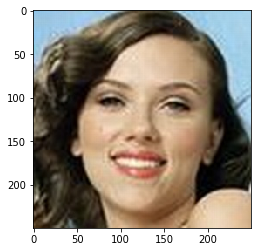

In [0]:
r = (real_img[1])
plt.imshow(r[:,:,::-1])


In [0]:
def fix(image):
    """
    This function should take a degraded image in BGR format as a 250x250x3
    numpy array with dtype np.uint8, and return its fixed version in the same format.

    Make sure you don't return floating point values, or RGB instead of BGR, else the
    image will look completely wrong when displayed.
    """
    image = np.reshape(image,(1,250,250,3))
    image = image/255
    image = tf.image.convert_image_dtype(image,tf.float32)
    img = trained_model(image)
    img = tf.image.convert_image_dtype(img,tf.uint8)
    img = np.reshape(img,(250,250,3))
    return img

# Results
Run this block after done to look at some of the results of the fix function. Do not change this block in any way. Instead write the fix function in a way that makes sure that this block works.

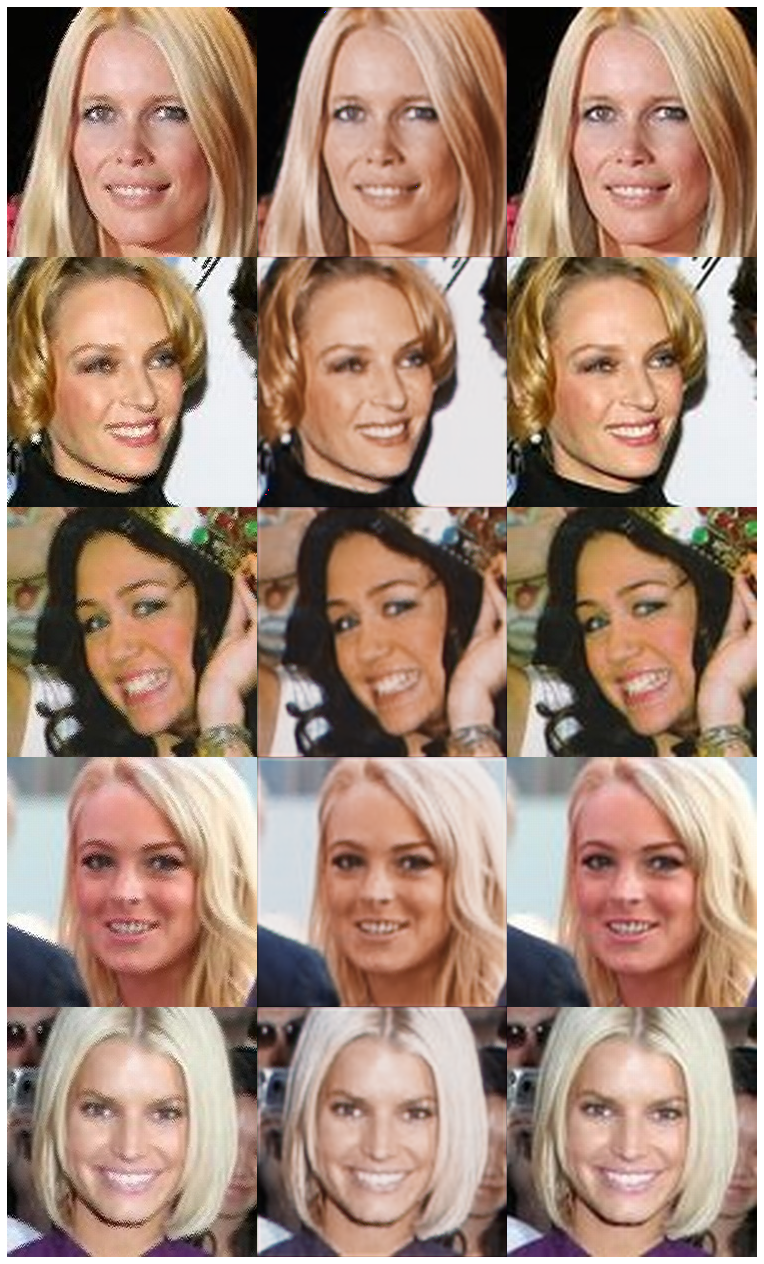

In [0]:
%matplotlib inline

import os
import random
from glob import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np

NUM_DISPLAY = 5

files = glob('/content/rephrase-pubfig831/correct/test/*/*')
grid = []

for path in random.sample(files, NUM_DISPLAY):
  correct = cv2.imread(path)
  split = path.split('/')
  degraded = cv2.imread('/'.join([*split[:3], 'degraded', *split[4:]]))
  #degraded = np.reshape(degraded , (1,250,250,3))
  fixed = fix(degraded)
  grid.append(np.column_stack([degraded, fixed, correct]))

image = np.row_stack(grid)
dpi = float(plt.rcParams['figure.dpi'])
figsize = image.shape[1] / dpi, image.shape[0] / dpi
ax = plt.figure(figsize=figsize).add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(image[..., ::-1])
plt.show()